### Метрики удержания

- return rate (конверсия возврата)
- churn rate (конверсия оттока)
- N-day retention (удержание на день N)

# return rate = (текущее количество активных пользователей из набора данных)/(общее количество пользователей из набора данных)*100

churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

<b>Что значит фраза "пользователь ушел в отток?"</b>

Ответ сильно зависит от сферы.

В общем случае ответ на вроде бы простой вопрос "ушел ли от нас пользователь" - нетривиален

#### Удержание N-го дня

- 1-day retention
- 3-day retention
- 7-day retention
- etc

Какая доля пользователей остается с нами на N-й день после установки (первой сессии)

Допустим, что мы умеем уже определить понятие "отток" (например, воспользовавшись методом из статьи https://arxiv.org/pdf/1907.03947.pdf)

Метрика1 (основная) - N-day retention

* ML-модель может ошибаться и в итоге в кампанию по удержанию попадут в том числе и те игроки, которые не собирались от нас уходить. Как следствие, на их удержание будут потрачены деньги (им будет сделано более выгодное предложение, хотя этого можно было и не делать)

При наличии модели с приемлемым качеством мы уже можем спланировать и провести эксперимент

1. скорим всю нашу аудиторию модель прогнозирования оттока и получаем вероятности оттока для каждого пользователя
2. сортируем пользователей по убыванию вероятности и берем топ Y%
3. проводим кампанию по удержанию полученной выборки
4. оцениваем результаты (превышает ли выручка от удержания расходы на это самое удержание)

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [103]:
# Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
# 1 - бустинг, 2 - логистическая регрессия
# (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
# Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
# Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных,
# как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного
#(True Positive) удержанного)

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [104]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


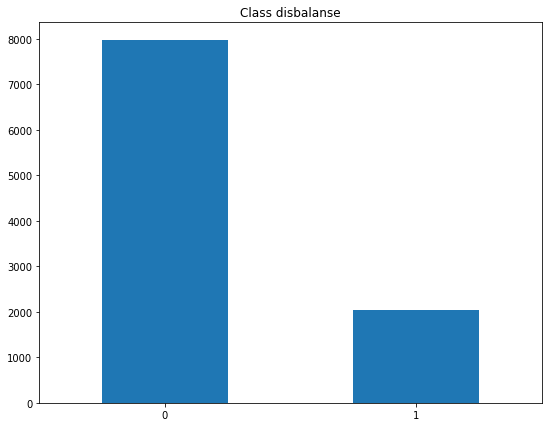

In [105]:
plt.figure(figsize=(9, 7))
plt.title('Class disbalanse')
df['Exited'].value_counts().plot(kind='bar')
plt.xticks(rotation=0);

In [106]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [107]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Зададим списки признаков

In [109]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# Почему 'Tenure' это категория?

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [110]:
# Все в функцию, с учетом нормализации
def give_data(categorical:list, continius:list, scale=False):
    final_transformers = list()

    for cat_col in categorical_columns:
        cat_transformer = Pipeline([
                    ('selector', FeatureSelector(column=cat_col)),
                    ('ohe', OHEEncoder(key=cat_col))
                ])
        final_transformers.append((cat_col, cat_transformer))
    if scale:
        for cont_col in continuous_columns:
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col)),
                        ('scaler', StandardScaler())  
                    ])
            final_transformers.append((cont_col, cont_transformer))
    else: 
        for cont_col in continuous_columns:
            cont_transformer = Pipeline([
                        ('selector', NumberSelector(key=cont_col)) 
                    ])
            final_transformers.append((cont_col, cont_transformer))
            
    return  final_transformers      

In [111]:
# обрабатываем тоже отдельно
trees_transformers = give_data(categorical_columns, continuous_columns)
distance_transformers = give_data(categorical_columns, continuous_columns, scale=True)

In [112]:
trees_feats = FeatureUnion(trees_transformers)
distance_feats = FeatureUnion(distance_transformers)

tree_processing = Pipeline([('feats', trees_feats)])
distance_processing = Pipeline([('feats', distance_feats)])

In [113]:
# модели и словарь с предсказаниями
models_dict = {'Bagging': BaggingClassifier(),
              'Catboost': CatBoostClassifier(silent=True),
               'KNN': KNeighborsClassifier(),
              'Logreg': LogisticRegression()
              }
preds_dict = {}

In [114]:
# и набиваем значениями в цикле
for name, model in models_dict.items():
    if name == 'Logreg' or name == 'KNN':
        pipline = Pipeline([
            ('features', distance_feats),
            ('classifier', model)
        ])
    else:
        pipline = Pipeline([
            ('features', trees_feats),
            ('classifier', model)
        ])
            
    pipline.fit(X_train, y_train)
    predictions = pipline.predict_proba(X_test)[:, 1]
    preds_dict[name] = predictions        
        

In [115]:
def show_metrics(y_test, y_preds, show=False):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_preds)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)

    precision = precision[ix]
    recall = recall[ix]
    f_score = fscore[ix]
    if show:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            f_score,
                                                                        precision,
                                                                        recall))
    else:    
        return precision, recall, f_score, thresholds[ix], ix 

In [116]:
# И в цикле смотрим на результат
# Возьмем KNN, у него получше precision, в этой задаче он важнее
for name, preds in preds_dict.items():
    print(name)
    show_metrics(y_test, preds, show=True)

Bagging
Best Threshold=0.500000, F-Score=0.602, Precision=0.623, Recall=0.583
Catboost
Best Threshold=0.325354, F-Score=0.644, Precision=0.616, Recall=0.674
KNN
Best Threshold=0.600000, F-Score=0.561, Precision=0.671, Recall=0.481
Logreg
Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


In [117]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [118]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score

def show_matrix(y_test, y_preds, threshold):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_preds>threshold)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

In [119]:
k_precision, k_recall, k_fscore, k_threshold, k_ix = show_metrics(y_test=y_test, y_preds=preds_dict['KNN'])
k_precision, k_recall, k_fscore, k_threshold, k_ix 

(0.6712328767123288, 0.481335952848723, 0.5606407322654462, 0.6, 3)

Confusion matrix, without normalization
[[1950   41]
 [ 377  132]]


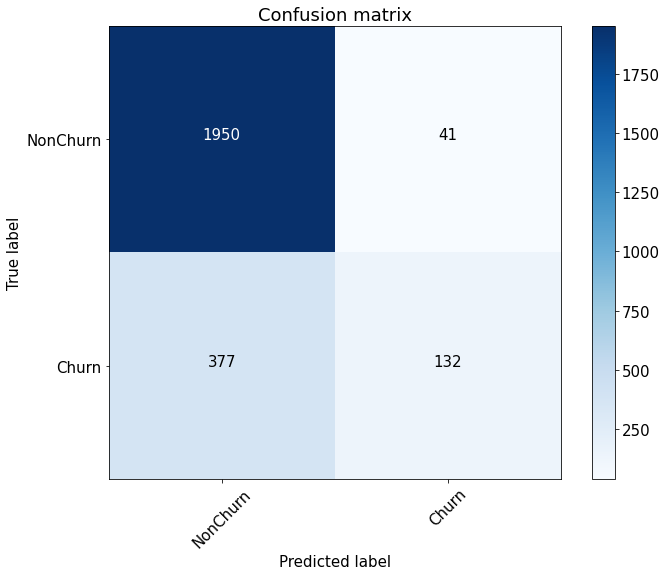

In [120]:
show_matrix(y_test, preds_dict['KNN'], k_threshold)

In [121]:
# Вот здесь я совмневаюсь, правильно?
def show_income(y_test, y_preds, threshold, profit, cost):
    error_matrics = confusion_matrix(y_test, y_preds>threshold)
    TP = error_matrics[0][0] # не отток, правильно
    TN = error_matrics[1][1] # отток, правильно
    FP = error_matrics[0][1] # не отток, модель определят как отток
    FN = error_matrics[1][0] # отток, модель определят как лояльных
    income = TN * profit - (TN * cost + FP * cost)
    return income
    

In [122]:
# слабовато по прибыли, попробуем улучшить
income = show_income(y_test, preds_dict['KNN'], k_threshold, 2, 1)
income

91

In [123]:
#(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

# Строим пайплайн отдельно
pipeline = Pipeline([
            ('features', distance_feats),
            ('classifier', KNeighborsClassifier())
        ])
            
pipline.fit(X_train, y_train)
predictions = pipline.predict_proba(X_test)[:, 1]

Сетка с параметрами

In [124]:
params={ 'classifier__n_neighbors':[5, 7, 10, 12],
         'classifier__weights':['uniform', 'distance'],
        'classifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
         'classifier__p':[1, 2]
        }

In [125]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__algorithm': 'auto',
 'classifier__n_neighbors': 12,
 'classifier__p': 2,
 'classifier__weights': 'distance'}

Обучаем модель уже сновыми параметрами

In [126]:
# Подбор параметров как всегда подвел, доделывала руками
pipeline = Pipeline([
    ('features',distance_feats),
    ('classifier', KNeighborsClassifier(n_neighbors=10, weights='uniform')),
     ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.400000, F-Score=0.597, Precision=0.596, Recall=0.599
Confusion matrix, without normalization
[[1878  113]
 [ 253  256]]


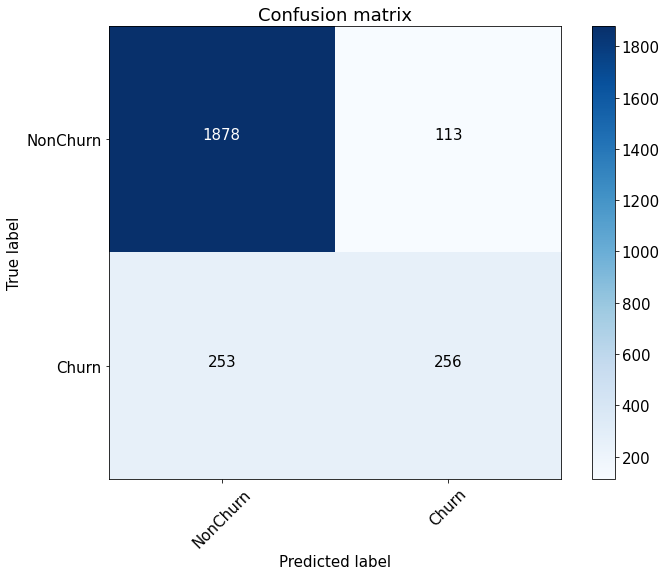

In [127]:
preds = pipeline.predict_proba(X_test)[:, 1]
show_metrics(y_test, preds, show=True)
k_precision, k_recall, k_fscore, k_threshold, k_ix = show_metrics(y_test, preds)
show_matrix(y_test, preds, k_threshold)

In [128]:
#(опционально) Еще раз провести оценку экономической эффективности
# Результат удалось улучшить, в отличие от Bagging - его тоже пробовала
# причем на старте там показатель выше, чем у KNN но после перебора вообще в минус уходит
income_2 = show_income(y_test, preds, k_threshold, 2, 1)

In [130]:
result = income_2 - income
if result > 0:
    print(f'Мы увеличили прибыль на {result} долларов')
else:
    print(f'Мы  потеряли {result} долларов')

Мы увеличили прибыль на 52 долларов


### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html